# Inference

This notebook is used to apply inference on the dataset used for training (pre-trained model will be loaded)

In [27]:
import torch
from torch.utils import data
from torch_utils import *

from utils import *

%config InlineBackend.figure_formats = ['png']
plt.style.use('seaborn-whitegrid')

## Loading data

Select paths where pre-computed models and data are stored

In [1]:
testing_data_path = '../dataset/test_example_multimode_v2/data_su/'
testing_label_path = '../dataset/test_example_multimode_v2/label/'

model_path = './model_multimode.pt'

Other parameters for data preprocessing and to compute dispersion panels for visualization purposes

In [29]:
# total depth
sizez = 70

# receiver axis
nx = 24
dx = 1
ox = 15

# time axis
t0 = 0.23
dt = 0.0005
nt = 1999

# velocities and frequencies for dispersion panels

cmin = 5
cmax = 2000
dc = 1.0
fmin = 5
fmax = 70
nperiod = 500  # number of samples in period/freq axis

x = np.arange(nx) * dx + ox
t = np.arange(nt) * dt

freq_fund = np.linspace(1 / 60, 1 / 5, 500)
freq_first = np.linspace(1 / 60, 1 / 15, 500)

period = np.linspace(1 / 60, 0.2, nperiod)

num_testing = 20

Load field data

In [30]:
set_seed(40)
idx = [-1, -2]
testing_data = []
testing_label = []
up = []

for m in np.random.randint(0, 150, num_testing):
    filename = str(m) + '_rvz.su'
    traces = read(testing_data_path + filename)

    for tt in range(len(traces)):
        traces[tt].data = cn(traces[tt].data, 3)  # add noise

        traces[tt] = traces[tt].trim(
            traces[tt].stats.starttime + t0, traces[tt].stats.starttime + t0 + 0.4)  # adjust time axis

    u = traces[0:len(traces)]
    unp = np.zeros((len(u), u[0].stats.npts), dtype='float32')

    for uu in range(len(u)):
        unp[uu] = u[uu].data
    up.append(u)
    testing_data.append(np.delete(unp, idx, 1))
    testing_label.append(
        np.load(testing_label_path + str(m) + '_label.npy'))

In [31]:
# Normalize
testing_data_norm = []
for k in range(len(testing_data)):
    testing_d_norm = testing_data[k] / \
        testing_data[k].max(axis=1)[:, np.newaxis]
    testing_data_norm.append(testing_d_norm)

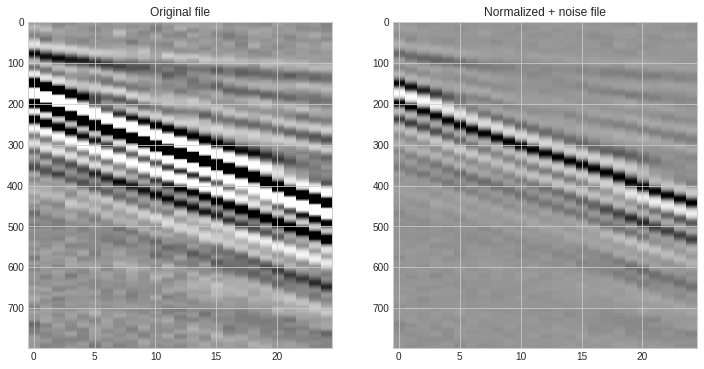

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
value = 1
axs[0].imshow(testing_data[value].T, cmap='Greys', norm = getnorm(testing_data[value], 4), interpolation='none')
axs[0].axis('tight')
axs[0].set_title('Original file')
axs[1].imshow(testing_data_norm[value].T, cmap='Greys', norm=getnorm(testing_data_norm[value].T), interpolation='none')
axs[1].axis('tight')
axs[1].set_title('Normalized + noise file');

## Inference

Prepare data for torch inference

In [33]:
idx = []

for n in range(num_testing):
    if testing_label[n].shape[0] != 1000:
        idx.append(n)

testing_data_norm = np.delete(testing_data_norm, idx, 0)
testing_label = [testing_label[l] for l in range(0, len(testing_label), 1) if l not in idx]
print(idx)

[]


In [34]:
testing_data_tensor = torch.Tensor(testing_data_norm)
testing_data_tensor = testing_data_tensor.reshape(testing_data_tensor.shape[0], 1, 
                                                  testing_data_tensor.shape[1], 
                                                  testing_data_tensor.shape[2])

testing_label_tensor = torch.Tensor(testing_label)

testing_dataset = data.TensorDataset(testing_data_tensor, testing_label_tensor) #add for synthetic

batch_size = 16
testing_loader = data.DataLoader(dataset=testing_dataset, batch_size=batch_size, num_workers=0)

Perform inference

In [35]:
device = torch.device('cpu')
model_eval = torch.load(model_path).to(device)
model_eval.eval()

outputs_list = []
labels_list = []

for bs, (shot_gathers, labels) in enumerate(tqdm(testing_loader)):
    outputs = model_eval(shot_gathers)
    outputs_list.append(outputs.detach().numpy())
    labels_list.append(labels.numpy())

100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Rearrange predictions for plotting

In [36]:
outputs_nparray = np.zeros((num_testing+1, outputs.shape[1]))
labels_nparray = np.zeros((num_testing+1, labels.shape[1]))

count = 0

for l in range(len(outputs_list)):
    for ll in range(len(outputs_list[l])):
        if l == 0:
            count = ll
            outputs_nparray[count] = outputs_list[l][ll]
            labels_nparray[count] = labels_list[l][ll]

        else:
            count = count + 1
            outputs_nparray[count] = outputs_list[l][ll]
            labels_nparray[count] = labels_list[l][ll]

In [37]:
ntmax = testing_data_norm[0].shape[1]
stats = Stats()
stats.starttime = 0.23
stats.delta = 0.0005
stats.npts = ntmax
up2 = []

for i in range(len(testing_data_norm)):
    stream = Stream()
    
    for j in range(testing_data_norm[i].shape[0]):
        stream.append(Trace(data=testing_data_norm[i][j].astype(np.float32), header=stats))
    up2.append(stream)

Display preditions

dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Frequency resolution up to 70.00 kHz: 27 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
dt:  0.0005
nt:  799
Fre

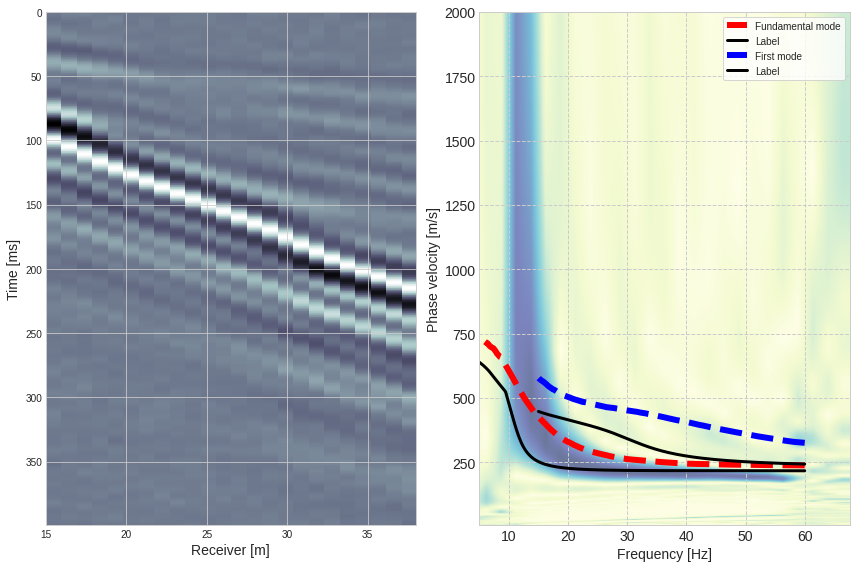

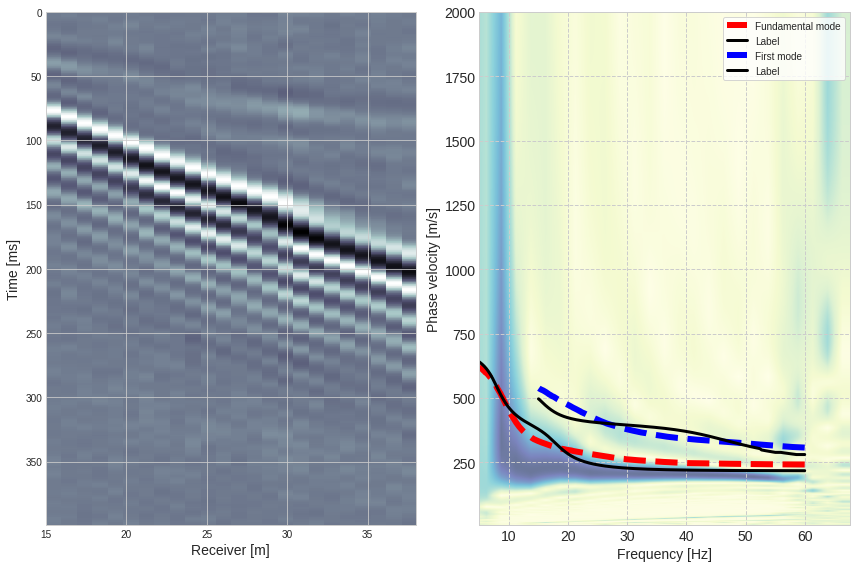

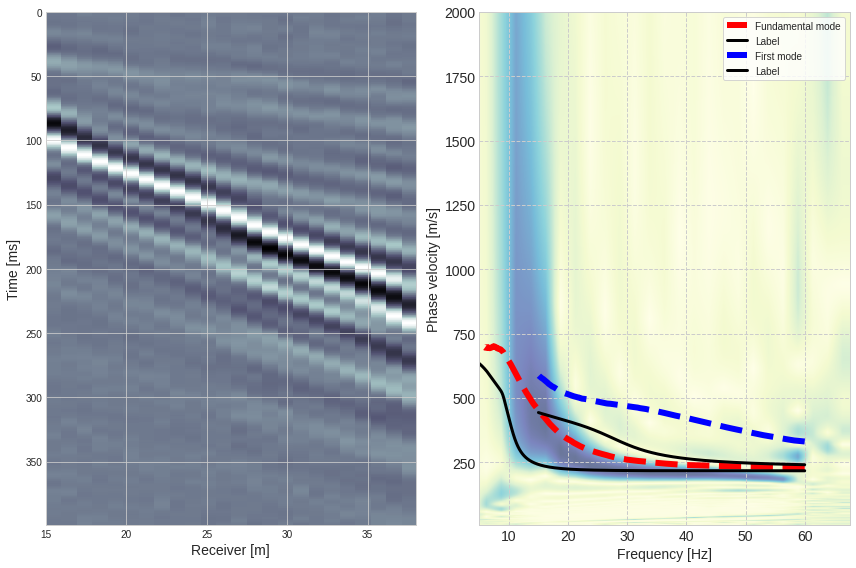

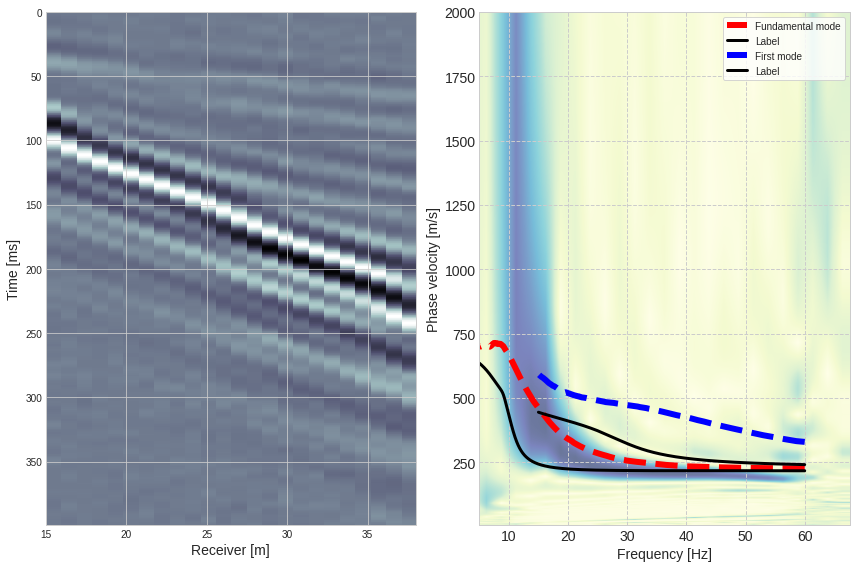

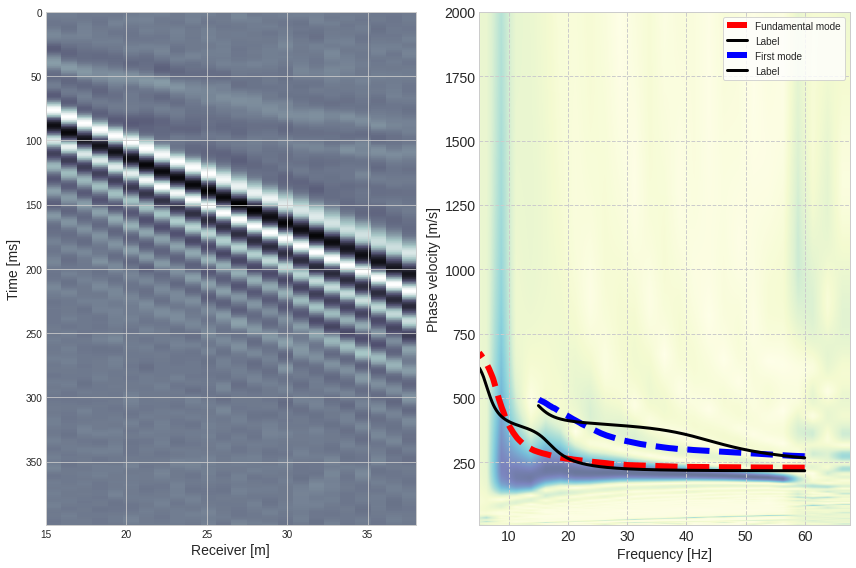

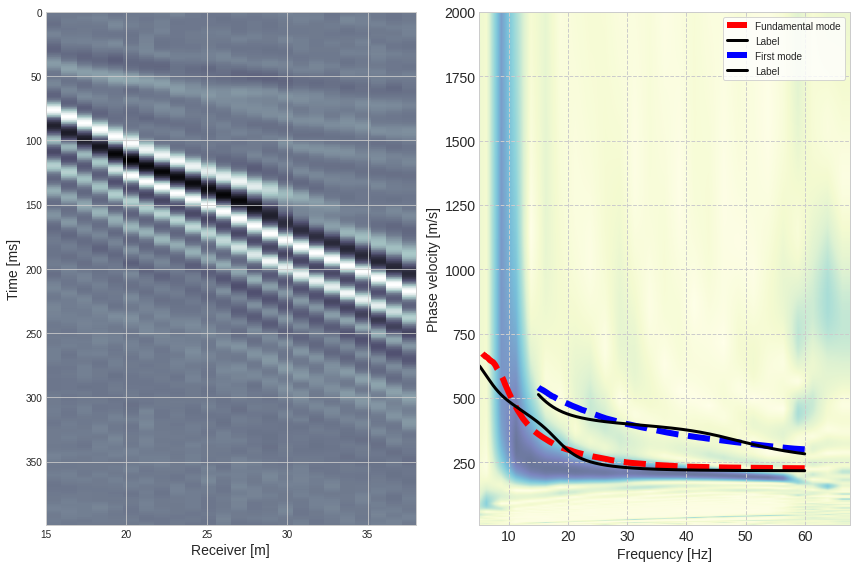

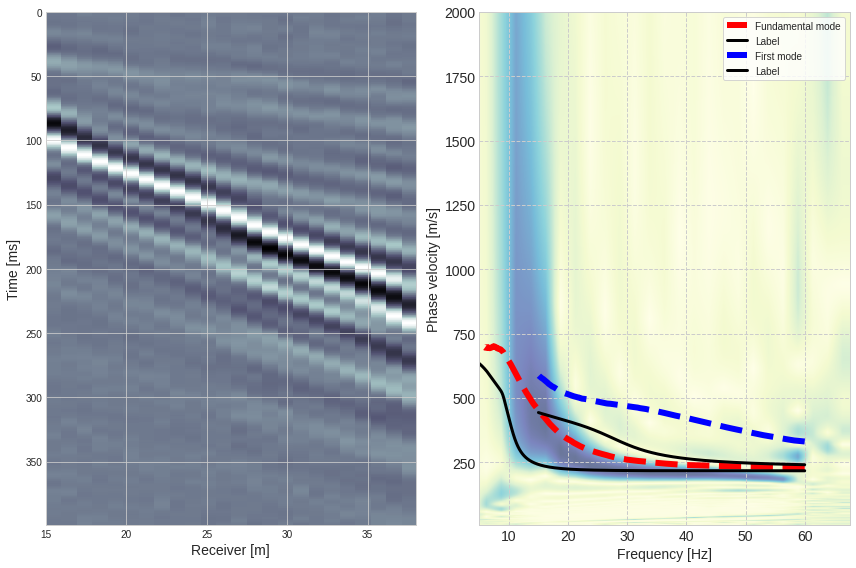

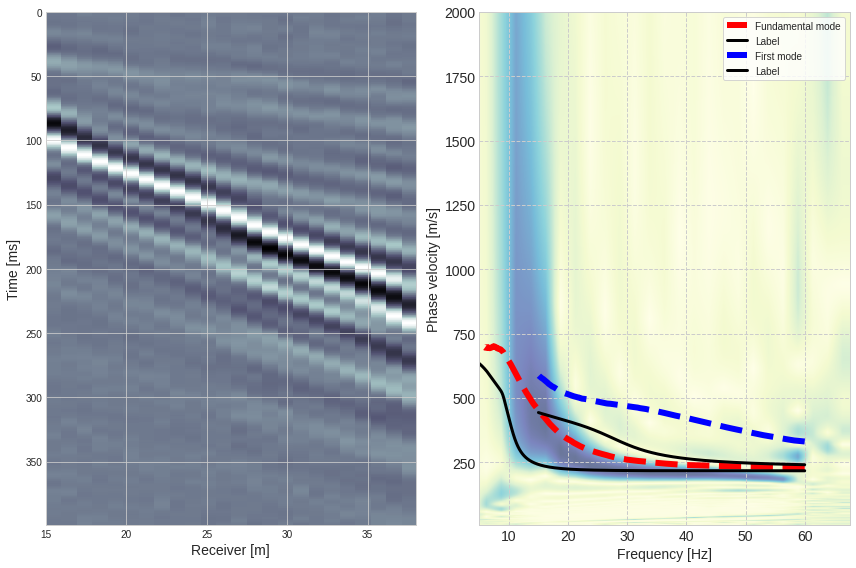

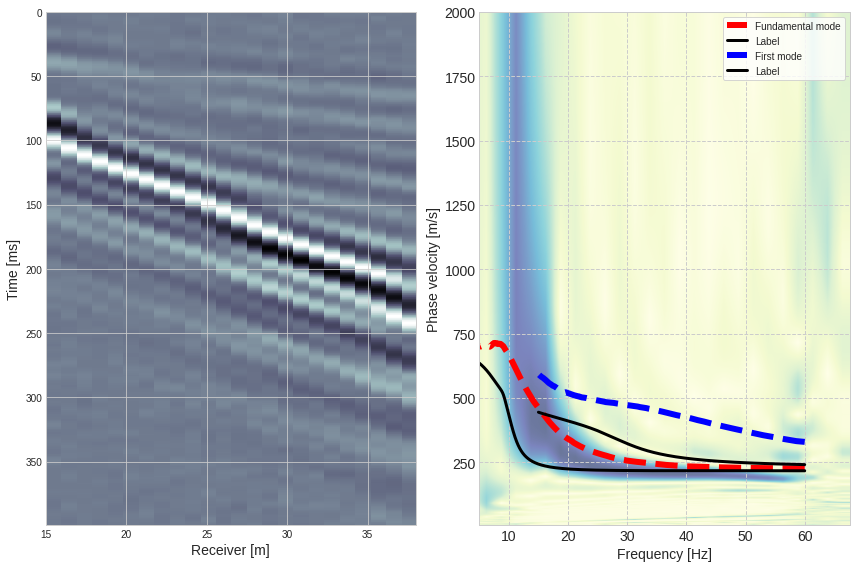

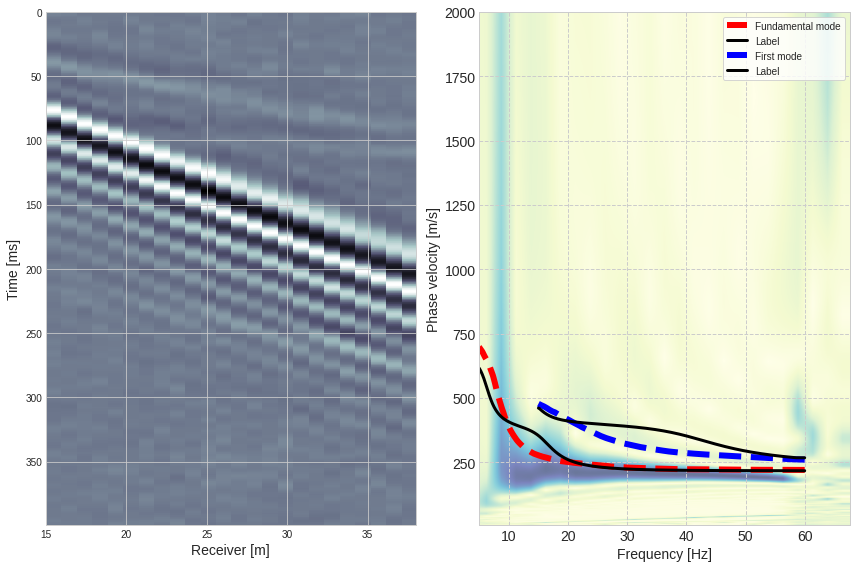

In [38]:
for n in np.random.randint(0,num_testing, 10):
    u2 = up2[n]
    data_su = np.array([u2[i].data for i in range(len(u2))]).T
    data_su = data_su[:, :nx]
    
    ## phase shift method
    f,c,img,fmax_idx,U,t = get_dispersion(u2.copy(),dx,cmin,cmax,dc,fmax)
    
    fig, (ax1,ax) = plt.subplots(1, 2, figsize=(12, 8))
    clip = 1e0
    ax1.imshow(data_su, cmap='bone', norm=getnorm(data_su), interpolation='nearest', extent=(x[0], x[-1], t[-1]*1000, t[0]*1000))
    ax1.axis('tight')
    ax1.set_xlabel('Receiver [m]', fontsize=14)
    ax1.set_ylabel('Time [ms]', fontsize=14)

    cax = ax.imshow(img[:,:],aspect='auto',origin='lower',cmap='YlGnBu',extent=(f[0],f[fmax_idx],c[0],c[-1]),alpha=0.6,interpolation='bilinear')
    ax.grid(linestyle='--',linewidth=1)
    c_line = np.zeros(fmax_idx)

    ax.set_xlabel('Frequency [Hz]', fontsize=14)
    ax.set_ylabel('Phase velocity [m/s]', fontsize=14)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 14)

    # For fundamental mode
    # np.linspace(5, 60, 500)
    plt.plot(1/freq_fund, outputs_nparray[n][:500], 'r--', linewidth=6, label='Fundamental mode')
    plt.plot(1/freq_fund, labels_nparray[n][:500], 'k', lw=3, label='Label')

   # For first mode
    plt.plot(1/freq_first, outputs_nparray[n][500:], 'b--', linewidth=6, label='First mode')
    plt.plot(1/freq_first, labels_nparray[n][500:], 'k', lw=3, label='Label')

    plt.xlim((fmin,f[fmax_idx]))
    plt.ylim((cmin,cmax))
    plt.legend(frameon=True)
    plt.tight_layout()